# Summary

Solve for a time-invariant or "steady-state" profile.

This is achieved by first integrating Hamilton's equations along an erosion ray trajectory initiated at a constant velocity "normal fault" boundary. Copies of this ray are then placed at uniformly spaced (vertically downwards) intervals along the boundary, generating a staggered time-sequence of rays whose ensemble positions at an appropriately chosen time slice constitute a time-invariant profile.

Visualization of the ray ensemble is carried out, along with graphing of properties of the time-invariant profile across the model domain. Comparison is made with the "steady-state" profile derived by integrating the model erosion equation directly (via a polynomial in $\mathrm{d}z/\mathrm{d}x$).

### Parameter files

In [1]:
# Specify the parameter files for the job
import os
if 'GME_NB_PR' not in os.environ.keys():
    pr_filenames = ['TimeInvariant_eta1p5_Ci5']
#     pr_filenames = ['TimeInvariant_sinbeta_ramp_eta1p5_ratio0p5_xiv10']
else:
    pr_filenames = eval(os.environ['GME_NB_PR'])

### Preliminaries

In [2]:
# Import Sympy and Numpy and set up latex inline & pretty dict printing
import sympy as sy, numpy as np
sy.init_printing(pretty_print=True,wrap_line=True)
from sympy import simplify, Matrix, Eq, Rational, rad, deg
from pprint import PrettyPrinter
pp = PrettyPrinter(indent=4).pprint

# Import Geomorphysics library functions, classes
from gmplib.utils import numify, export_results, e2d, omitdict, convert
from gmplib.save import create_directories, export_plots
from gmplib.parameters import import_parameters, Parameters

# Import GME classes and do a wildcard (!) import of all GME symbol definitions
from gme.symbols import *
from gme.equations import Equations, EquationSubset
from gme.ode_raytracing import TimeInvariantSolution
from gme.plot import TimeInvariantPlots, ManuscriptPlots

#
from matplotlib import pyplot as plt

# Decide where we're working and thus where to find the job parameter files
#   -  use the GME_WORKING_PATH environment variable if it's defined
#   -  otherwise, deduce that we're working in the GME notebook dir
if 'GME_WORKING_PATH' in os.environ.keys():
    working_path = os.environ['GME_WORKING_PATH']
    print(f'Fetching working path from environment variable GME_WORKING_PATH = {working_path}')
else:
    from gmplib.utils import get_pkg_path
    import gme
    working_path = get_pkg_path(gme, dirname='')
    print(f'Deducing working path from GME package location = {working_path}')
    del gme
    
# Set the path to the parameter files for this nb and report
pr_path = os.path.join(working_path,'Parameters','RayTracing')
pr_path, pr_filenames

Deducing working path from GME package location = /Users/colinstark/Projects/GME


('/Users/colinstark/Projects/GME/Parameters/RayTracing',
 ['TimeInvariant_eta1p5_Ci5'])

In [3]:
# Read and combine the default and job parameter files, and report

parameters_dict,_ = import_parameters([pr_path], [os.path.join('..','defaults'), *pr_filenames])
pr = Parameters(parameters_dict, evaluations={}, sequence=())
pr.job.group_name = 'Schematics'
pr.job.short_name = 'sch'
[pp(psubobj.__dict__) for psubobj in (pr.job, pr.model, pr.solve, pr.resolve, pr.plot, pr.save)];

{   'debug': False,
    'group_name': 'Schematics',
    'short_name': 'sch',
    'subtitle': '',
    'title': 'Time-invariant profile solution: sin(beta), ramp, eta=3/2, '
             'mu=3/4, Ci=5deg',
    'verbose': True,
    'very_verbose': False}
{   'Ci': pi/36,
    'Lc': 10000,
    'beta_type': 'sin',
    'do_geodesic': False,
    'eta': 3/2,
    'h_0': 1/2,
    'ibc_type': 'concave-up',
    'kappa_h': 3/2,
    'mu': 3/4,
    't_xiv0_list': None,
    'varepsilonhat': 1/50,
    'varphi_0': 2.641e-05,
    'varphi_type': 'ramp',
    'x_h': 1,
    'x_sigma': 0.01,
    'xiv_0': None}
{   'choice': 'Hamilton',
    'do_dense': True,
    'do_geodesic': True,
    'do_ic': False,
    'do_ip': False,
    'do_vb': False,
    'ic_res': 31,
    'ip_res': 101,
    'method': {'Hamilton': 'DOP853', 'geodesic': 'LSODA'},
    'ray_n_t': 301,
    't_distribn': 2,
    't_end': 5,
    'vb_res': 101}
{   'do_eliminate_caustics': True,
    'n_isochrones': 30,
    'spline_order': 3,
    't_isochrone_max

In [4]:
# pr.model.varepsilonhat = Rational(1,50)
# pr.model.Ci=rad(5)

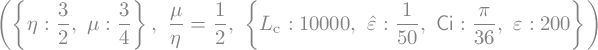

In [5]:
# Create a dict of the key physics parameters to be used in substitutions
subexp = {
    eta: pr.model.eta,
    mu: pr.model.mu
}
sub = {
    Ci: pr.model.Ci, 
    Lc: pr.model.Lc, 
    varepsilonhat: pr.model.varepsilonhat, 
    varepsilon: pr.model.varepsilonhat*pr.model.Lc
}
subexp, Eq(mu/eta,pr.model.mu/pr.model.eta), sub

# Equations

Derive the GME equation set (using Sympy) for a specific erosion model.

In [6]:
gmeq = Equations( eta=pr.model.eta, 
                  mu=pr.model.mu, 
                  beta_type=pr.model.beta_type, 
                  varphi_type=pr.model.varphi_type, 
                  ibc_type=pr.model.ibc_type,
                  do_idtx=True,
                  do_raw=True )

# Integration

Integrate Hamilton's equations in $(\mathbf{r}, \mathbf{\widetilde{p}})[t]$ for a given vertical component of the erosion rate (initial condition) equivalent to a constant vertical velocity (boundary condition). In other words, given a value for vertical slip rate $\xi^{\downarrow}$ at the boundary at $x=0$, where the initial ray position is $\left.(r^x, r^z)\right|_{t=0} = (0,0)$, specify the initial value of the vertical component of the normal-slowness covector $p_z[t=0] = \left.-1/\xi^{\downarrow}\right|_{x=0}$.  The horizontal component of the initial covector $p_x[t=0]$ is computed by calculating the surface gradient $\left.\tan\beta\right|_{x=0}$ from the erosion model and then using $-p_x/p_z = \tan\beta$.

Create an instance of the ODE solution object.

In [7]:
pr.model.beta_0 = float(beta_0.subs(e2d(gmeq.beta0_Ci_eqn
                                        .subs(omitdict(sub,[beta_0])).subs(subexp))))
sub.update({beta_0:pr.model.beta_0})
convert(Eq(beta_0, pr.model.beta_0), n=2, units=degrees, do_raw=False)

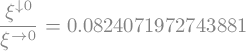

In [8]:
xivh0_ = float((xiv_0/xih_0).subs(e2d(gmeq.xiv0_xih0_Ci_eqn)).subs(sub).subs(subexp).n())
sub.update({(xiv_0/xih_0):xivh0_})
Eq(xiv_0/xih_0, sub[xiv_0/xih_0])

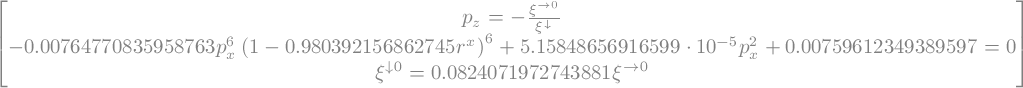

In [9]:
gmeq_ndim_subset = EquationSubset(gmeq, sub, do_ndim=True, do_revert=True) 
Matrix([
    gmeq_ndim_subset.pz_xiv_eqn,
    gmeq_ndim_subset.poly_px_xiv0_eqn,
    gmeq_ndim_subset.xiv0_xih0_Ci_eqn
])

In [10]:
xmax_ = 0.999 #float(1-varepsilonhat.subs(sub))

In [11]:
gmes = TimeInvariantSolution( gmeq_ndim_subset, parameters=sub, 
                              t_end=pr.solve.t_end, t_distribn=pr.solve.t_distribn, 
                              x_stop=xmax_,
                              n_t=pr.solve.ray_n_t,
                              choice=pr.solve.choice, 
                              method=pr.solve.method[pr.solve.choice],
                              do_dense=pr.solve.do_dense )

Solve Hamilton's ODEs using DOP853 method of integration


Set of initial conditions for the ray.

In [12]:
gmes.initial_conditions()

Perform integration of the coupled ODEs.

In [13]:
gmes.solve()
print('Message: {}\nSuccess? {}\nStatus: {}\nt_final: {}\nrx_final: {}'
      .format(gmes.solns[0].message, gmes.solns[0].success,
              gmes.solns[0].status, gmes.solns[0].t[-1], gmes.solns[0].y[0][-1]) )

Message: A termination event occurred.
Success? True
Status: 1
t_final: 3.8135555555555563
rx_final: 0.998712261189895


Process the above output, which takes the form of time series of positions $\{\mathbf{r}\}$ and front normal slownesses  $\{\mathbf{\widetilde{p}}\}$, into various arrays.

In [14]:
gmes.postprocessing(spline_order=pr.resolve.spline_order)
gmes.more_postprocessing(spline_order=pr.resolve.spline_order)

Generate a time-invariant profile by spatially integrating the topographic gradients implied by the time series of front normal slownesses  $\{\mathbf{\widetilde{p}}\}$. 

This profile can alternatively be generated by synthesizing a staggered sequence of rays and gathering all the ray positions $\{\mathbf{r}\}$ for a chosen time slice. This has already been done in the post-processing step.

In [15]:
gmes.integrate_h_profile(do_truncate=True, x_max=1) #xmax_

# Plots

Generate explanatory figures for publication 

## Preliminaries

In [17]:
prefix = pr.job.short_name

suffix  = f'_eta{float(sy.N(pr.model.eta))}'
suffix += f'_Ci{float(sy.N(sy.deg(pr.model.Ci)))}'

job_name = prefix+suffix.replace('.','p')
job_name

'sch_eta1p5_Ci5p0'

In [222]:
gr1 = TimeInvariantPlots()
gr2 = ManuscriptPlots()

## Topo cross-section

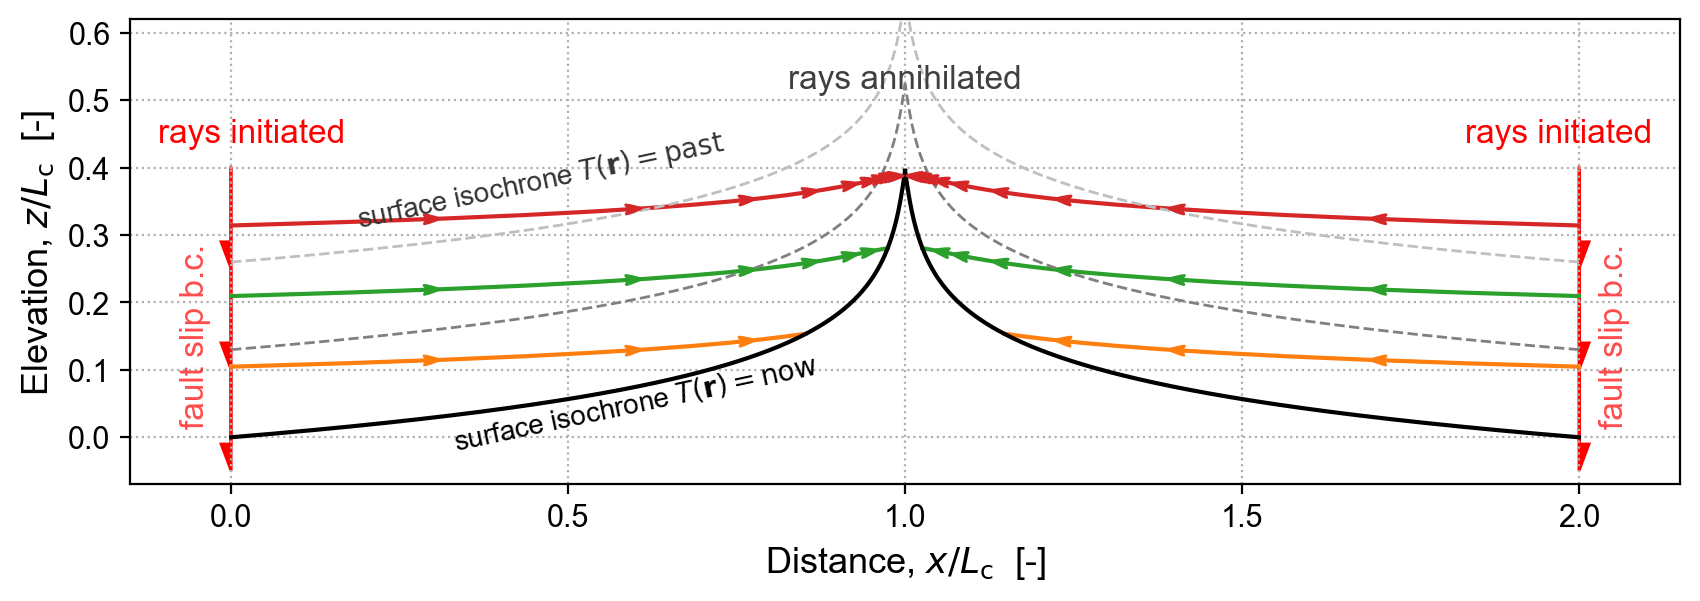

In [223]:
gr1.profile_h_rays( gmes, gmeq, sub, job_name+'_tis_cross_section', 
                    fig_size=(10,7), n_points=31, n_rays=3, profile_subsetting=1, 
                    do_direct=True, do_schematic=True )

## Pairing schematic

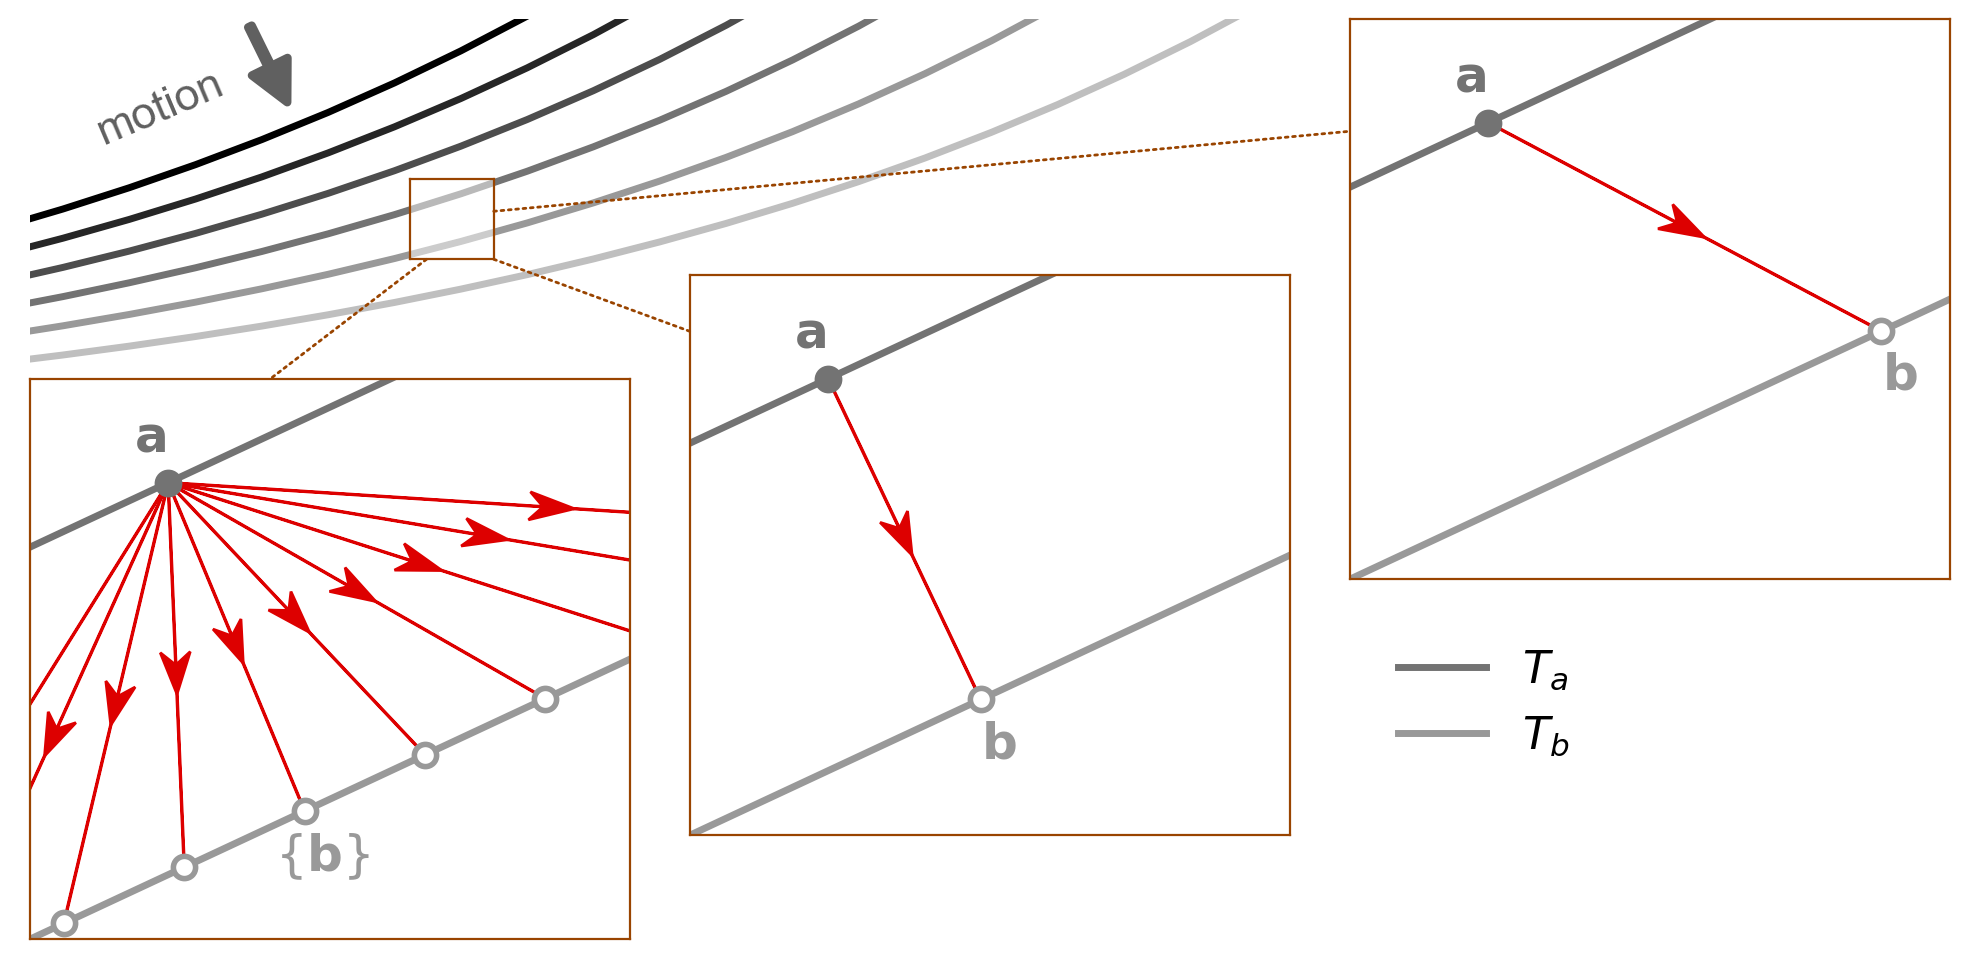

In [481]:
def remove_ticks_etc(axes_):
#     return
    axes_.set_xticklabels([])
    axes_.set_xticks([])
    axes_.set_yticklabels([])
    axes_.set_yticks([])
    axes_.set_xlim(0,1)
    axes_.set_ylim(0,1)
    
def linking_lines(fig_, axes_A, axes_B, axes_C, axes_D, gray1, gray2, brown_):
    joins = [0]*3
    kwargs = dict(color=brown, linestyle=':')
    joins[0] = ConnectionPatch(xyA=(0.2,0), coordsA=axes_D.transData, 
                               xyB=(0.4,1),  coordsB=axes_A.transData, **kwargs)
    joins[1] = ConnectionPatch(xyA=(1,0.00), coordsA=axes_D.transData, 
                               xyB=(0,0.9),  coordsB=axes_B.transData, **kwargs)
    joins[2] = ConnectionPatch(xyA=(1,0.60), coordsA=axes_D.transData, 
                               xyB=(0,0.8),  coordsB=axes_C.transData, **kwargs)
    [fig_.add_artist(join_) for join_ in joins]
        
def make_xy():
    x = np.linspace(0,1)
    x_ndim = (x-0.5)/(0.9-0.5)
    y = np.exp((0.5+x)*4)/120
    return x_ndim,y
    
def isochrones_subfig(fig_, x_, y_):
    # Top left isochrones 0
    size_zoom_0 = [0.65, 0.55]
    posn_0 = [0.0, 0.75]
    gray_ = gr2.gray_color(2,5)
    axes_0 = fig_.add_axes([*posn_0, *size_zoom_0]) 
    plt.axis('off')
    n_isochrones = 6
    i_gray, n_gray = 5, 6
    [plt.plot(x_, sf_*y_, '-', color=gr2.gray_color(i_,n_gray), lw=2.5) 
         for i_, sf_ in enumerate(np.linspace(0.5,1.2,n_isochrones))]
    gray1 = gr2.gray_color(1,n_gray)
    gray2 = gr2.gray_color(2,n_gray)
    plt.xlim(0,1)
    plt.ylim(0,1)
    sf1_ = 1.3
    sf2_ = 1.3
    arrow_xy_ = np.array([0.2,0.8])
    arrow_dxy_ = np.array([-0.025,0.15])
    motion_xy_ = [0.1,0.8]
    motion_angle_ = 23
    my_arrow_style = ArrowStyle.Simple(head_length=1*sf1_, head_width=1*sf1_, 
                                       tail_width=0.1*sf1_)
    axes_0.annotate('', xy=arrow_xy_, xytext=arrow_xy_+arrow_dxy_*sf2_,
                    transform=axes_0.transAxes, 
                    arrowprops=dict(arrowstyle=my_arrow_style, color=gray_, lw=3))
    plt.text(*motion_xy_, 'motion', color=gray_, fontsize=16, rotation=motion_angle_, 
             transform=axes_0.transAxes, 
             horizontalalignment='center', verticalalignment='center')
    return axes_0, posn_0, gray1, gray2


    
def set_colors(obj_type, axes_list, color_):
    [[child.set_color(color_) for child in axes_.get_children() 
     if isinstance(child, obj_type)] for axes_ in axes_list]

def zoom_boxes(fig_, gray1, gray2):
    size_zoom_AB = [0.3,0.7]
    size_zoom_C = [0.3,0.7]
    brown_ = '#994400'
    n_pts = 300
    
    def zoomed_isochrones(axes_, i_pt1_, i_pt2_, 
                          gray1_=gr2.gray_color(5-1,8), gray2_=gr2.gray_color(5-2,8), 
                          do_many=False, do_legend=False):
        x_array = np.linspace(-1,3, n_pts)
        y_array1 = x_array*0.5
        y_array2 = y_array1+0.7
        
        # Ta
        plt.plot(x_array, y_array2, '-', color=gray2_, lw=2.5, label=r'$T_a$')
        xy_pt2 = np.array([x_array[i_pt2_],y_array2[i_pt2_]])
        marker_style2 = dict(marker='o', fillstyle='none', markersize=8, 
                             markeredgecolor=gray2_, markerfacecolor=gray2_, 
                             markeredgewidth=2 )
        plt.plot(*xy_pt2, **marker_style2)
        plt.text(*(xy_pt2+np.array([-0.03,0.08])), r'$\mathbf{a}$', 
                 color=gray2_, fontsize=18, rotation=0, transform=axes_.transAxes,
                 horizontalalignment='center', verticalalignment='center')
        # Tb
        plt.plot(x_array, y_array1, '-', color=gray1_, lw=2.5, label=r'$T_b$')
        i_pts1 = [i_pt1_]
        xy_pts1_tmp = np.array([np.array([x_array[i_pt1__],y_array1[i_pt1__]]) 
                            for i_pt1__ in i_pts1])        
        xy_pts1 = xy_pts1_tmp.T.reshape((xy_pts1_tmp.shape[2],2)) if do_many else xy_pts1_tmp
        marker_style1 = marker_style2.copy()
        marker_style1.update({'markeredgecolor':gray1_,'markerfacecolor':'w'})
        [plt.plot(*xy_pt1_, **marker_style1) for xy_pt1_ in xy_pts1]
        b_label_i = 4 if do_many else 0
        b_label_xy = (xy_pts1[b_label_i]+np.array([0.03,-0.08]))
        b_label_text = r'$\{\mathbf{b}\}$' if do_many else r'$\mathbf{b}$'
        plt.text(*b_label_xy, b_label_text, 
                 color=gray1_, fontsize=18, rotation=0, transform=axes_.transAxes,
                 horizontalalignment='center', verticalalignment='center')
        
        if do_legend:
            plt.legend(loc=[0.05,-0.35], fontsize=16, framealpha=0)
        
        return (xy_pts1 if do_many else xy_pts1[0]), xy_pt2
    
    def v_arrow(axes_, xy_pt1_, xy_pt2_):
        af_ = 0.55
        v_color = '#dd0000'
        axes_.arrow(*xy_pt2_,*((xy_pt1_-xy_pt2_)*af_), 
                     lw=1, facecolor=v_color, edgecolor=v_color, 
                     head_width=0.05, overhang=0.3,
                     transform=axes_.transAxes, length_includes_head=True, )
        axes_.arrow(*(xy_pt2_+(xy_pt1_-xy_pt2_)*af_),*((xy_pt1_-xy_pt2_)*(1-af_)), 
                     lw=1, facecolor=v_color, edgecolor=v_color, 
                     transform=axes_.transAxes, length_includes_head=True, )
    
    # From zoom box D
    posn_D = np.array(posn_0) + np.array([0.19,0.25])
    size_zoom_D = [0.042,0.1]
    axes_D = fig_.add_axes([*posn_D, *size_zoom_D]) 
    remove_ticks_etc(axes_D)
    axes_D.patch.set_alpha(0.5)
    
    # Zoom any point pairing A
    posn_A = [0,0.15]
    axes_A = fig_.add_axes([*posn_A, *size_zoom_AB]) 
    remove_ticks_etc(axes_A)
    i_pt2_A = 92
    i_pts1_A = [i_pt2_A+i_ for i_ in np.arange(-43,100,15)]
    xy_pts1_A, xy_pt2_A = zoomed_isochrones(axes_A, i_pts1_A,i_pt2_A, 
                                           gray1, gray2, do_many=True)
    [v_arrow(axes_A, xy_pt1_A, xy_pt2_A) for xy_pt1_A in xy_pts1_A]

    # Zoom intrinsic pairing B
    posn_B = [0.33,0.28]
    axes_B = fig_.add_axes([*posn_B, *size_zoom_AB]) 
    remove_ticks_etc(axes_B)
    i_pt2_B = i_pt2_A
    i_pt1_B = i_pt2_A+19
    xy_pt1_B, xy_pt2_B = zoomed_isochrones(axes_B, i_pt1_B,i_pt2_B, 
                                           gray1, gray2)
    v_arrow(axes_B, xy_pt1_B, xy_pt2_B)

    # Zoom erosion-fn pairing C
    posn_C = [0.66,0.6]
    axes_C = fig_.add_axes([*posn_C, *size_zoom_C]) 
    remove_ticks_etc(axes_C)
    i_pt1_C = i_pt1_B+30
    i_pt2_C = i_pt2_B
    xy_pt1_C, xy_pt2_C = zoomed_isochrones(axes_C, i_pt1_C,i_pt2_C, 
                                           gray1, gray2, do_legend=True)
    v_arrow(axes_C, xy_pt1_C, xy_pt2_C)
    
    # Brown zoom boxes and tie lines
    set_colors(Spine, [axes_A, axes_B, axes_C, axes_D], brown_)
    return axes_A, axes_B, axes_C, axes_D, brown_

# Build fig
from matplotlib.spines import Spine
from matplotlib.patches import ArrowStyle, ConnectionPatch, FancyArrowPatch
fig = gr2.create_figure('sch_point_pairing', fig_size=(10, 4));

x,y = make_xy()
axes_0, posn_0, gray1, gray2 = isochrones_subfig(fig, x, y)
axes_A, axes_B, axes_C, axes_D, brown = zoom_boxes(fig, gray1, gray2)
linking_lines(fig, axes_A, axes_B, axes_C, axes_D, gray1, gray2, brown)

## Covector schematic

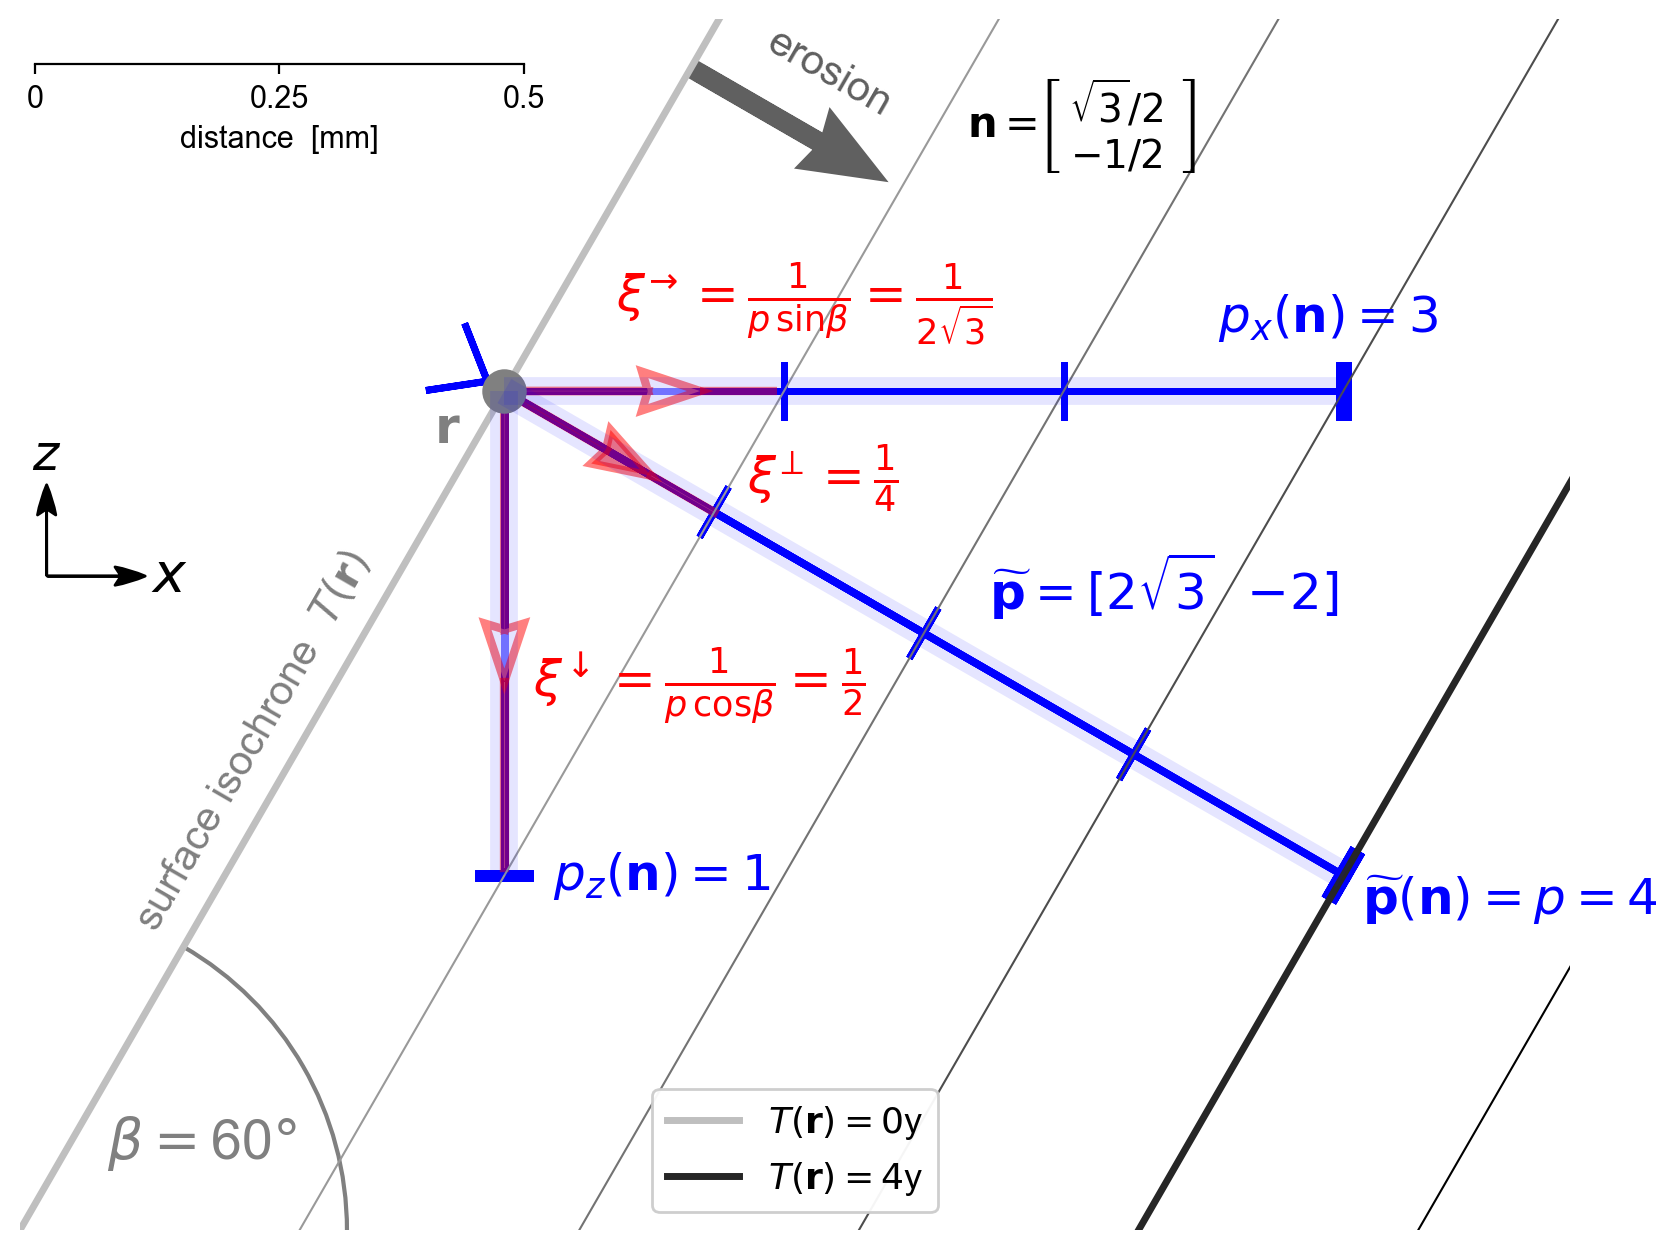

In [221]:
gr2.covector_isochrones(name='sch_covector_isochrones', fig_size=(10,10))

## Hugyens schematics

0: 111


AttributeError: 'EquationSubset' object has no attribute 'varphi_rx_eqn'

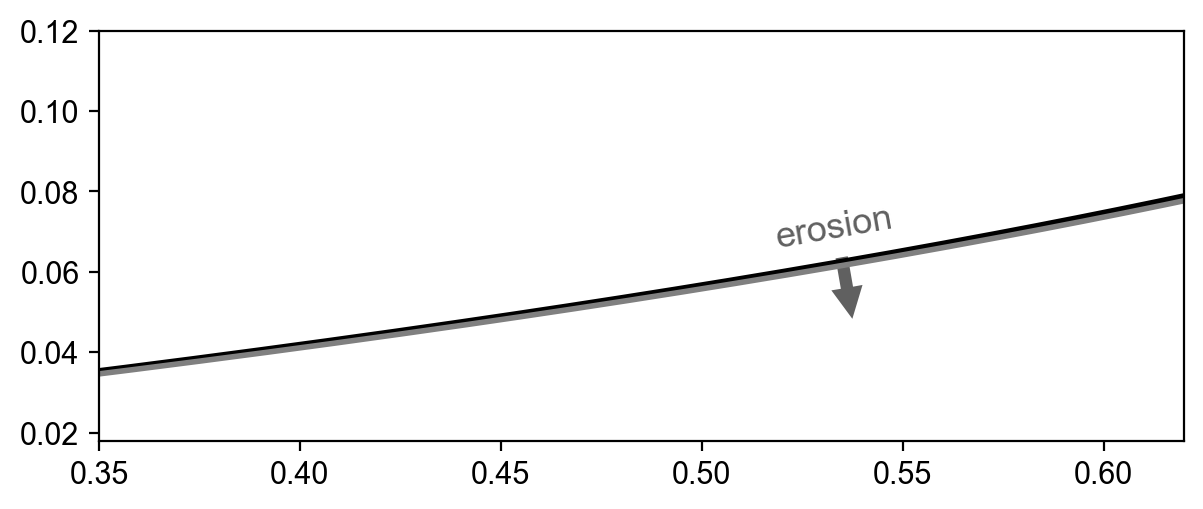

In [296]:
gr2.huygens_wavelets( gmes, gmeq_ndim_subset, sub, job_name+'_ray_conjugacy', fig_size=(7,6),
                      do_ray_conjugacy=True, do_legend=False, annotation_fontsize=13 )

0: 111


TypeError: can't convert expression to float

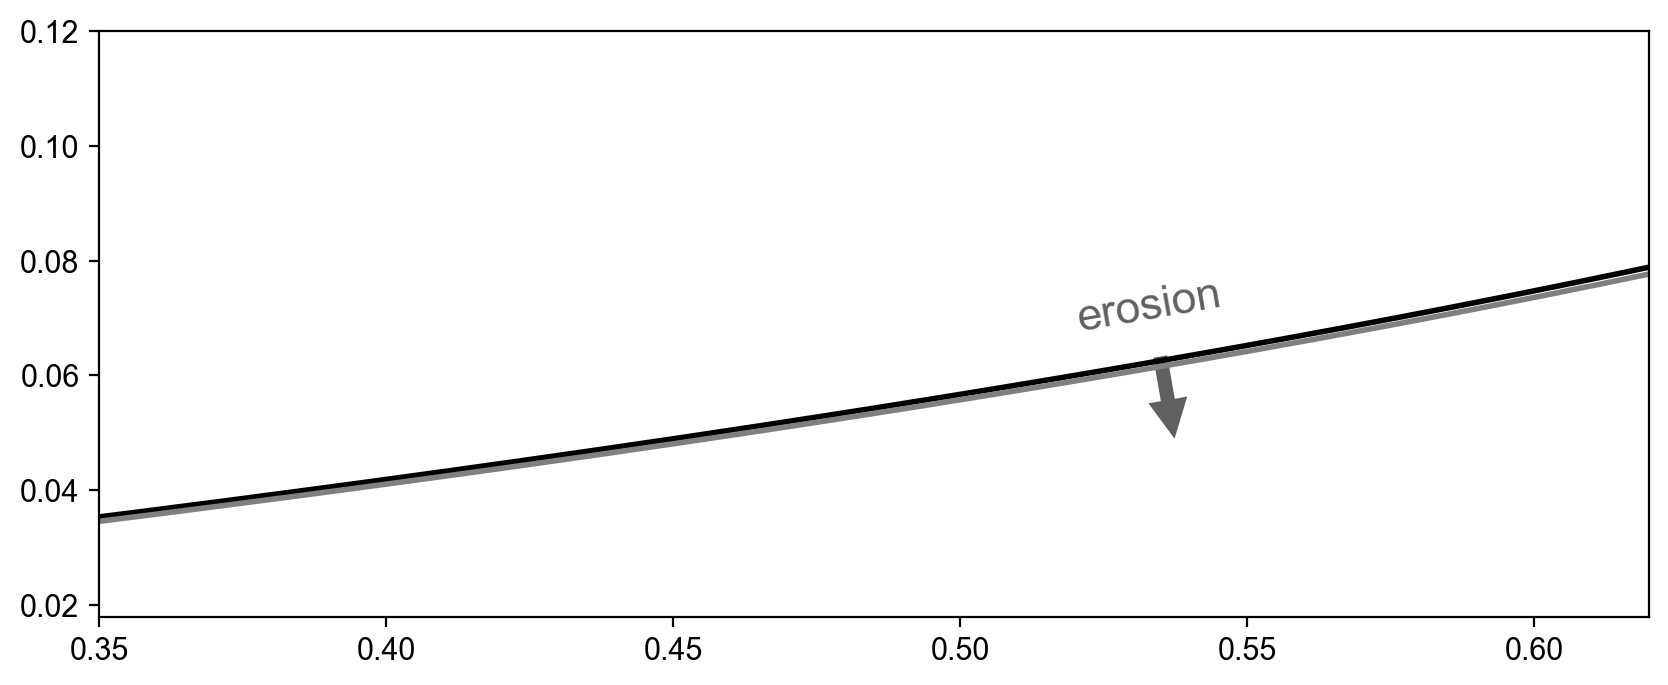

In [297]:
gr2.huygens_wavelets( gmes, gmeq, sub, job_name+'_ray_conjugacy_legend', fig_size=(10,6),
                      do_ray_conjugacy=True, do_legend=True, legend_fontsize=9,
                      annotation_fontsize=16 )

0: 0


TypeError: can't convert expression to float

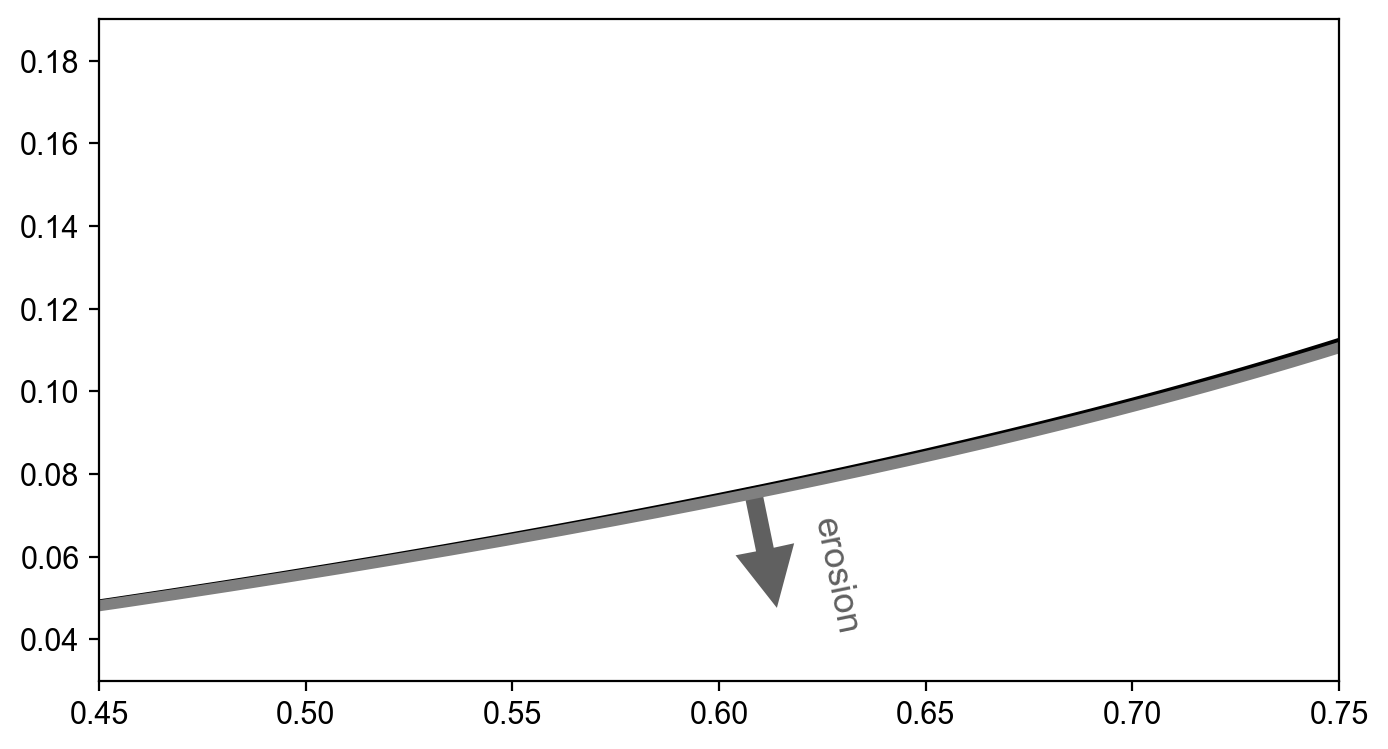

In [298]:
gr2.huygens_wavelets( gmes, gmeq, sub, job_name+'_huygens_wavelets', fig_size=(8,6),
                      do_legend=True, annotation_fontsize=13 )

In [ ]:
# gr.profile_flow_model( gmes, gmeq, sub, job_name+'_flow_model', fig_size=(5,4),
#                        subtitle=pr.job.subtitle, n_points=51,
#                        do_extra_annotations=pr.plot.do_extra_annotations )

In [ ]:
# gr.profile_slope_area( gmes, gmeq, sub, job_name+'_slope_area', fig_size=(5,4),
#                        subtitle=pr.job.subtitle, n_points=51,
#                        do_extra_annotations=pr.plot.do_extra_annotations,
#                        do_simple=not pr.plot.do_ray_conjugacy );

In [ ]:
# gr.profile_h_rays( gmes, gmeq, sub, job_name+'_schematic', fig_size=(10,7), n_points=31,
#                    ray_subsetting=pr.plot.ray_subsetting//2, do_direct=True, do_schematic=True )

In [ ]:
# if pr.plot.do_profile_extra:
#     gr.profile_h_rays( gmes, gmeq, sub, job_name+'_h_rays_extra', fig_size=(10,7), 
#                        ray_subsetting=pr.plot.ray_subsetting, n_points=pr.plot.rays_n_points,
#                        do_simple=True )

# Save

Export the graphs as PNG and/or PDF image files.

In [482]:
plots_dir = create_directories(pr.save.figs_path, pr.job.group_name)
[export_plots( gr.fdict, plots_dir, pr.save.figs_format, suffix='' ) for gr in [gr1, gr2]];

Writing to dir: "/Users/colinstark/Projects/GME/Plots/Schematics"
Exported "sch_eta1p5_Ci5p0_tis_cross_section.png"
Writing to dir: "/Users/colinstark/Projects/GME/Plots/Schematics"
Exported "sch_point_pairing.png"
Exported "sch_eta1p5_Ci5p0_ray_conjugacy.png"
Exported "sch_eta1p5_Ci5p0_ray_conjugacy_legend.png"
Exported "sch_eta1p5_Ci5p0_huygens_wavelets.png"
